## Data Reading

In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 29.9 MB/s 
     |████████████████████████████████| 7.6 MB 51.7 MB/s 
     |████████████████████████████████| 182 kB 64.5 MB/s 


In [2]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 9.0 MB/s 


In [104]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from google.colab import files
import pandas as pd
import imageio as iio
import cv2
from google.colab.patches import cv2_imshow
from transformers import ViTFeatureExtractor, ViTForImageClassification
from PIL import Image as img
from IPython.display import Image, display
import scipy.io
import os
import json
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yassirbenabdallah","key":"496619d8473a927ba69c046148c8f5c9"}'}

In [5]:
!mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets list

ref                                                             title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                   5MB  2022-11-13 15:47:17          12155        364  1.0              
michals22/coffee-dataset                                        Coffee dataset                                    24KB  2022-12-15 20:02:12           2599         68  1.0              
thedevastator/jobs-dataset-from-glassdoor                       Salary Prediction                                  3MB  2022-11-16 13:52:31           7500        165  1.0              
thedevastator/unlock-profits-with-e-commerce-sales-data         E-Commerce 

In [9]:
!kaggle datasets download -d diyer22/retail-product-checkout-dataset

100% 25.3G/25.3G [01:56<00:00, 196MB/s]
100% 25.3G/25.3G [01:56<00:00, 234MB/s]


In [10]:
!unzip retail-product-checkout-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: val2019/20180830-10-06-26-1881.jpg  
  inflating: val2019/20180830-10-06-33-1881.jpg  
  inflating: val2019/20180830-10-10-30-1481.jpg  
  inflating: val2019/20180830-10-10-49-1481.jpg  
  inflating: val2019/20180830-10-11-12-1481.jpg  
  inflating: val2019/20180830-10-13-16-1886.jpg  
  inflating: val2019/20180830-10-13-21-1886.jpg  
  inflating: val2019/20180830-10-13-27-1886.jpg  
  inflating: val2019/20180830-10-14-51-1486.jpg  
  inflating: val2019/20180830-10-14-59-1486.jpg  
  inflating: val2019/20180830-10-15-08-1486.jpg  
  inflating: val2019/20180830-10-19-12-1891.jpg  
  inflating: val2019/20180830-10-19-17-1891.jpg  
  inflating: val2019/20180830-10-19-33-1491.jpg  
  inflating: val2019/20180830-10-19-43-1491.jpg  
  inflating: val2019/20180830-10-19-55-1491.jpg  
  inflating: val2019/20180830-10-24-30-1896.jpg  
  inflating: val2019/20180830-10-24-36-1896.jpg  
  inflating: val2019/20180830-10-24-44-1896.jpg  

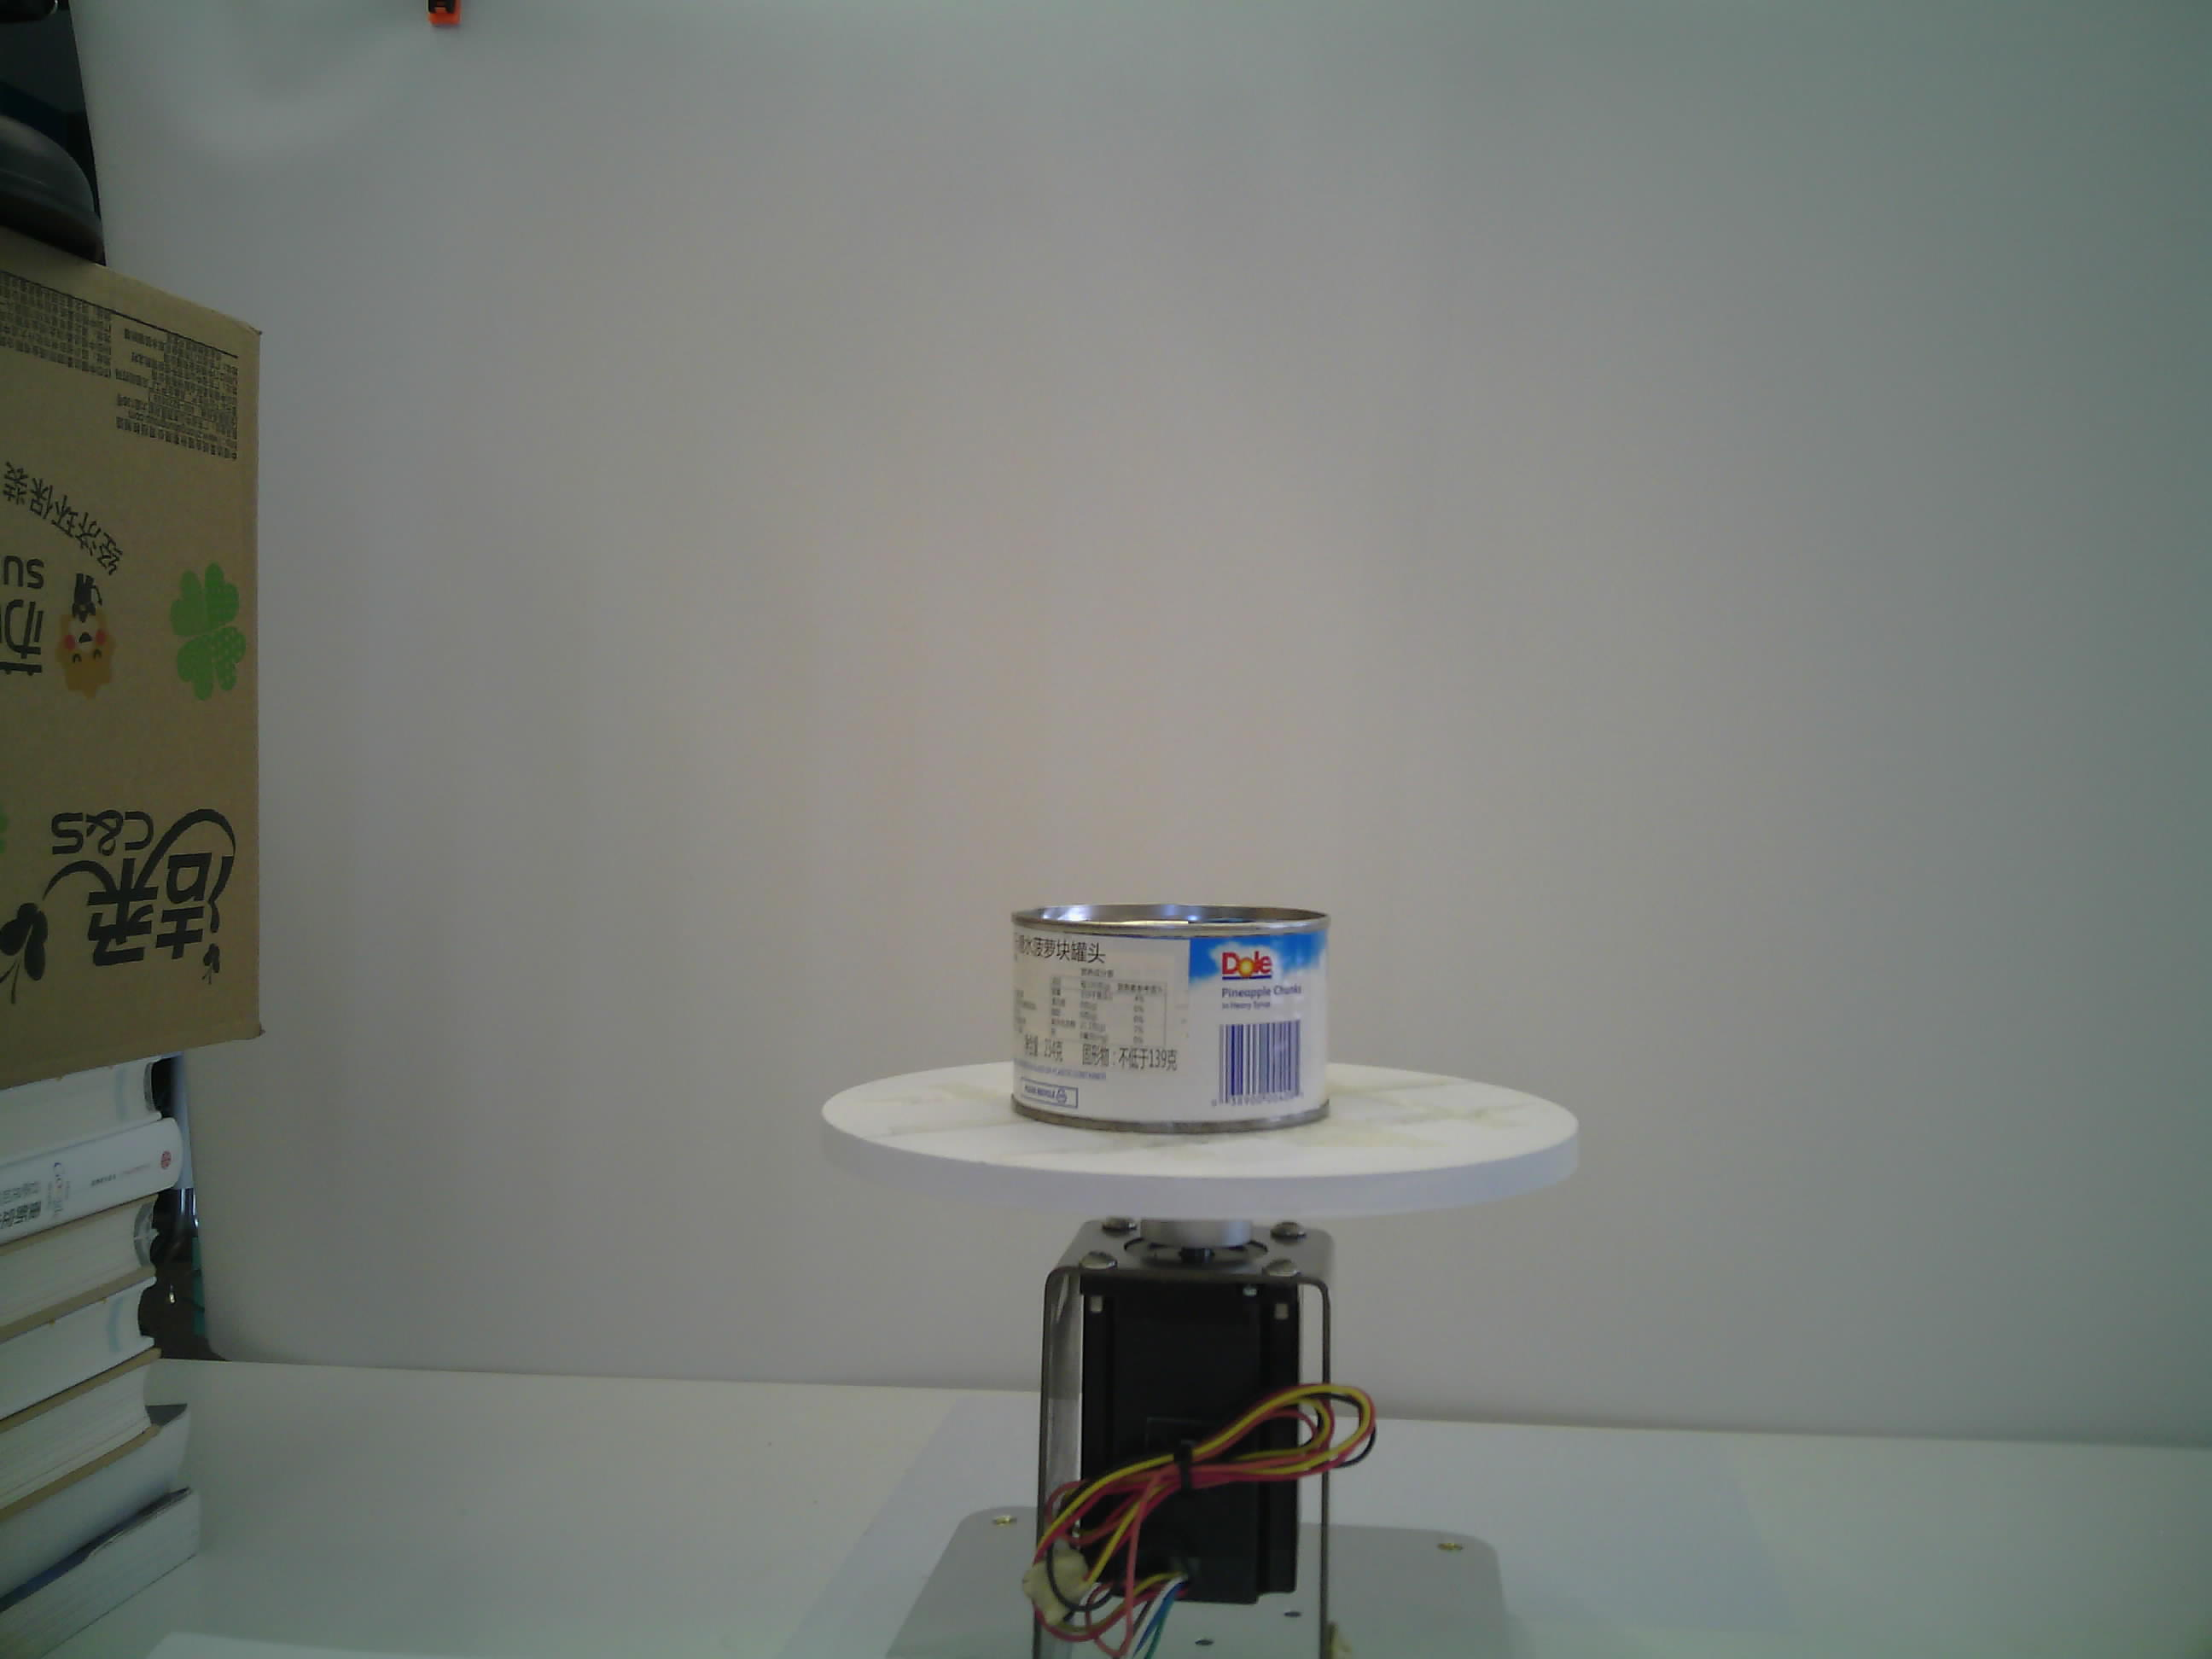

In [11]:
img = cv2.imread('/content/train2019/038900004095_camera0-10.jpg')
cv2_imshow(img)

## Data Augmentation Techniques

In [105]:
import imgaug.augmenters as iaa
import glob

In [106]:
train_file = 'train2019'
train_annot_json = 'instances_train2019.json'
train_annot = 'train_annot'

test_file = 'test2019'
test_annot_json = 'instances_test2019.json'
test_annot = 'test_annot'

val_file = 'val2019'
val_annot_json = 'instances_val2019.json'
val_annot = 'val_annot'

In [14]:
# Path of the training images
image_paths = [
    f for f in os.listdir(train_file) if os.path.isfile(os.path.join(train_file, f))
]

# Path of the tesing images
test_images_paths = [
    f for f in os.listdir(test_file) if os.path.isfile(os.path.join(test_file, f))
]

# Path of the validation images
val_images_paths = [
    f for f in os.listdir(val_file) if os.path.isfile(os.path.join(val_file, f))
]

In the following lines of code, we are perfroming data augmentation using multiple techniques:

*   **Flip:** using *fliplr* we are performing a horizontal flip while *flipud* does vertical flip
*   **Affine:** here we perform transaltion on the image on both the x axis and the y axis. Also we can perform rotation. Sacle option can either zoom in or zoom out the image.
*   **Multiply:** this method plays with the channels of the image in the sense that it makes the image brighter or darker.
*   **Guassian Blur:** here we randomly blur the image using a Gaussian distribution.



In [15]:
augmentation = iaa.Sequential([
    # Flip
    iaa.Fliplr(0),
    iaa.Flipud(0.5),

    # Affine
    iaa.Affine(translate_percent = {"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
               rotate = (-25, 25),
               scale = (0.5, 1.5)),
              
    # Multiply
    iaa.Multiply((0.8, 0.3)),

    # Guassian Blur
    iaa.GaussianBlur((0.0, 0.5))
])

Unfortunately, we were unable to process this data augmentation code because of computational limitations!

In [ ]:
# Add augmented data to the training file
images = []
images_path = glob.glob("train2019/*.jpg")
for img_path in images_path:
  img = cv2.imread(img_path)
  images.append(img)

for i in range(len(image_paths)):
  augmented_images = augmentation(images = images)
  for img in augmented_images:
    image_paths.append(img)

## Data Pre-Processing & Splitting

In [16]:
! mkdir train_annot

In [17]:
! mkdir test_annot

In [18]:
! mkdir val_annot

The Keras code we got inspired from used MatLab files from which it reads the annotation which includes the coordinates of the bounding boxes. Therefore, we adopted the same technique. We built a function to write the annotations in MAT files.

In [19]:
def writeToMATFile(folder, fileName, data):
  fullName = folder + '/' + fileName + '.mat'
  scipy.io.savemat(fullName, data)

In [21]:
# Write training annotations in MAT file
f = open(train_annot_json)
keys = json.load(f)

folder = train_annot
j = 0
for i in keys['annotations']:
  fileName = image_paths[j]
  writeToMATFile(folder, fileName, i)
  j = j+1

In [23]:
# Write testing annotations in MAT file
f = open(test_annot_json)
keys = json.load(f)

folder = test_annot
j = 0
for i in keys['annotations']:
  fileName = test_images_paths[j]
  writeToMATFile(folder, fileName, i)
  j = j+1

In [25]:
# Write validation annotations in MAT file
f = open(val_annot_json)
keys = json.load(f)

folder = val_annot
j = 0
for i in keys['annotations']:
  fileName = val_images_paths[j]
  writeToMATFile(folder, fileName, i)
  j = j+1

The following lines of code show we stored the annotation paths into lists. Theses lists will be used when processing the images, especially for training images.

In [26]:
annot_paths = [
    f for f in os.listdir(train_annot) if os.path.isfile(os.path.join(train_annot, f))
]

annot_paths_test = [
    f for f in os.listdir(test_annot) if os.path.isfile(os.path.join(test_annot, f))
]

annot_paths_val = [
    f for f in os.listdir(val_annot) if os.path.isfile(os.path.join(val_annot, f))
]

When we created the MAT files that include the annotations, we gave them the same name as their corresponding images. So, we thought it would be better to sort both the images' paths and the annotations' paths in order not to search for the corresponding annotation of a certain image when processing them.

In [27]:
image_paths.sort()
annot_paths.sort()

test_images_paths.sort()
annot_paths_test.sort()

val_images_paths.sort()
annot_paths_val.sort()

In [28]:
image_size = 224  # resize input images to this size

In [29]:
# images list store the training images in a form of a numpy array, while targets stores the bounding box coordinates for each image.
images, targets = [], []

# loop over the annotations and images (for training), preprocess them and store in lists
for i in range(0, len(annot_paths)-53639):
    # Access bounding box coordinates
    annot = scipy.io.loadmat(train_annot + '/' + annot_paths[i])["bbox"][0]

    top_left_x, top_left_y = annot[2], annot[0]
    bottom_right_x, bottom_right_y = annot[3], annot[1]

    image = keras.utils.load_img(
        train_file + '/' + image_paths[i],
    )
    (w, h) = image.size[:2]

    # resize train set images
    if i < int(len(annot_paths)-53639):
    #     # resize image if it is for training dataset
        image = image.resize((image_size, image_size))

    # convert image to array and append to list
    images.append(keras.utils.img_to_array(image))

    # apply relative scaling to bounding boxes as per given image and append to list
    targets.append(
        (
            float(top_left_x) / w,
            float(top_left_y) / h,
            float(bottom_right_x) / w,
            float(bottom_right_y) / h,
        )
    )

In [30]:
images_test, targets_test = [], []

# loop over the annotations and images (for testing), preprocess them and store in lists
for i in range(0, len(annot_paths_test)-23900):
    # Access bounding box coordinates
    annot_test = scipy.io.loadmat(test_annot + '/' + annot_paths_test[i])["bbox"][0]

    top_left_x, top_left_y = annot_test[2], annot_test[0]
    bottom_right_x, bottom_right_y = annot_test[3], annot_test[1]

    image = keras.utils.load_img(
        test_file + '/' + test_images_paths[i],
    )
    (w, h) = image.size[:2]

    # resize test set images
    if i < int(len(annot_paths_test)-23900):
    #     # resize image if it is for training dataset
        image = image.resize((image_size, image_size))

    # convert image to array and append to list
    images_test.append(keras.utils.img_to_array(image))

    # apply relative scaling to bounding boxes as per given image and append to list
    targets_test.append(
        (
            float(top_left_x) / w,
            float(top_left_y) / h,
            float(bottom_right_x) / w,
            float(bottom_right_y) / h,
        )
    )

In [31]:
images_val, targets_val = [], []

# loop over the annotations and images (for testing), preprocess them and store in lists
for i in range(0, len(annot_paths_val)-5900):
    # Access bounding box coordinates
    annot_val = scipy.io.loadmat(val_annot + '/' + annot_paths_val[i])["bbox"][0]

    top_left_x, top_left_y = annot_val[2], annot_val[0]
    bottom_right_x, bottom_right_y = annot_val[3], annot_val[1]

    image = keras.utils.load_img(
        val_file + '/' + val_images_paths[i],
    )
    (w, h) = image.size[:2]

    # resize validation set images
    if i < int(len(annot_paths_val)-5900):
    #     # resize image if it is for training dataset
        image = image.resize((image_size, image_size))

    # convert image to array and append to list
    images_val.append(keras.utils.img_to_array(image))

    # apply relative scaling to bounding boxes as per given image and append to list
    targets_val.append(
        (
            float(top_left_x) / w,
            float(top_left_y) / h,
            float(bottom_right_x) / w,
            float(bottom_right_y) / h,
        )
    )

In [32]:
(x_train), (y_train) = (
    np.asarray(images[: len(images)]),
    np.asarray(targets[: len(targets)]),
)
(x_test), (y_test) = (
    np.asarray(images[int(len(images_test) * 0.8) :]),
    np.asarray(targets[int(len(targets_test) * 0.8) :]),
)

## Patch Creation

The following class helps in building patches that are supposed to play the role of the grid of our images. 

In [107]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # return patches
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

We can visualize how patches are using the following lines of code.

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


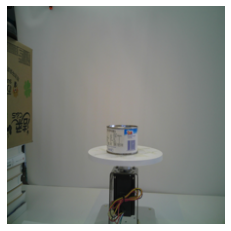

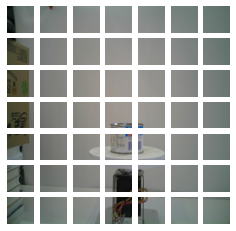

In [108]:
patch_size = 32  # Size of the patches to be extracted from the input images

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(tf.convert_to_tensor([x_train[0]]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Patch Encoding Layer

The following class helps in building a class for flattening the patches into a vector called projection_dim. Also, it also takes care of assigning the projection_dim a learnable position, which is used to encode the position of each patch within the input image, so that the model can differentiate between the order of each patch.

In [109]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Transfer Learning

We are using a pre-trained model as a starting point to train a new model on our dataset. The model we are taking as a reference is **imagenet21k_ViT-B_8**, which is a variant of ViT model that been trained on the ImageNet21k dataset. the **8** at the name refers to the number of attention block is it is composed of. The model was trained on the ImageNet21k dataset, which is a larger version of the ImageNet dataset that contains over 21,000 classes and over 14 million images.

In [45]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [87]:
weights = np.load('/content/gdrive/MyDrive/imagenet21k_ViT-B_8.npz')

The following line of code shows the types of the layers that were used in building the model:


*   encoder_norm: a layer that is made up of self-attn and feedforward network.
*   LayerNorm: normalize the activations of the block over the batch dimension.
*   MlpBlock: refers to the implementation of MLP (Multilayer Layer Perceptron). Its role is to transform the ouput of the transformer layers into a prediction for the image class. 
*   MultiHeadDotProductAttention: this another layer within the encoder that is a type of self-attention mechanism. It allows the model to attend to different parts of the input sequence in parallel, allowing it to capture dependencies between different parts of the input and make more informed predictions.
*   cls: refers to the classifier layer of a transformer model. The classifier layer is a fully connected layer that is used to make predictions based on the output of the transformer model.
*   embedding: this layer takes care of representing patches as numerical vectors that can be processed then by the encoder.

In [102]:
for k in weights.keys():
  print(k)

Transformer/encoder_norm/bias
Transformer/encoder_norm/scale
Transformer/encoderblock_0/LayerNorm_0/bias
Transformer/encoderblock_0/LayerNorm_0/scale
Transformer/encoderblock_0/LayerNorm_2/bias
Transformer/encoderblock_0/LayerNorm_2/scale
Transformer/encoderblock_0/MlpBlock_3/Dense_0/bias
Transformer/encoderblock_0/MlpBlock_3/Dense_0/kernel
Transformer/encoderblock_0/MlpBlock_3/Dense_1/bias
Transformer/encoderblock_0/MlpBlock_3/Dense_1/kernel
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/key/bias
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/key/kernel
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/out/bias
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/out/kernel
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/query/bias
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/query/kernel
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/value/bias
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/value/kernel
T

As the model was implemented using pytorch, we had to build some layers with properties that do not exist in tensorflow. For example, **TransformerEncoderLayer** was built to satisfy the needs of encoder_norm that already exists in pytorch. 

In [97]:
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model=10, num_heads, ffn_dim=2048, rate=0.1):
        super(TransformerEncoderLayer, self).__init__()

        self.self_attention = tf.keras.layers.MultiHeadAttention(
            d_model, num_heads, dropout=rate)
        self.feed_forward = tf.keras.layers.Dense(
            ffn_dim, activation='relu')
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attention_output, _ = self.self_attention(
            inputs, inputs, inputs, training=training)
        attention_output = self.dropout1(attention_output, training=training)
        attention_output = self.norm1(attention_output + inputs)

        ffn_output = self.feed_forward(attention_output)
        ffn_output = self.dropout2(ffn_output, training=training)
        output = self.norm2(ffn_output + attention_output)

        return output

We made sure to add some regularization techniques within this MLP, such as the drop rate. Also, there is some room for fin *tuning*, such as playing the number of hidden units as well as the activation functions.

In [103]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

We define some variables that contribute in building a ViT model that matches the criterias of the weights in imagenet21k_ViT-B_8. For example, the number of transformer layers that should be 8. 

In [111]:
input_shape = (image_size, image_size, 3)  # input image shape
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 10
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers

In [112]:
def create_vit_object_detector2(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):

    inputs = TransformerEncoderLayer(num_heads)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        print(x1)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create embiddings 
    embeddings = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    embeddings = layers.Flatten()(embeddings)
    embeddings = layers.Dropout(0.3)(embeddings)
    
    # Add MLP.
    features = mlp(embeddings, hidden_units=mlp_head_units, dropout_rate=0.3)

    bounding_box = layers.Dense(4)(
        features
    )  # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_box)


In [117]:
# Create a new model
model = create_vit_object_detector2(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

In [118]:
# Initialize the weights of the new model using the weights from the pre-trained model
for name, param in model.named_parameters():
    if name in weights:
        param.data = weights[name]

In [121]:
model.weights

[<tf.Variable 'patch_encoder_10/dense_174/kernel:0' shape=(3072, 64) dtype=float32, numpy=
 array([[-0.00568787, -0.01435582, -0.02285038, ...,  0.02842587,
          0.02911869,  0.00721798],
        [-0.0465898 ,  0.03750702, -0.01492011, ...,  0.0054065 ,
         -0.03547547, -0.00402403],
        [ 0.04033346,  0.03228164,  0.00055064, ..., -0.02075684,
          0.01962627, -0.0092922 ],
        ...,
        [-0.00472643,  0.04291064, -0.00036293, ...,  0.00373789,
          0.01490885,  0.00273947],
        [-0.00472712, -0.01135456, -0.00409378, ...,  0.01118399,
          0.0134973 , -0.03602256],
        [ 0.02774221,  0.03228927, -0.01134292, ...,  0.00445409,
          0.03344977, -0.01712164]], dtype=float32)>,
 <tf.Variable 'patch_encoder_10/dense_174/bias:0' shape=(64,) dtype=float32, numpy=
 array([-3.9138836e-03,  8.2227495e-03, -4.9849208e-03, -4.6543311e-03,
        -5.3863649e-05,  1.4996019e-03, -7.0645344e-03, -4.8084790e-03,
        -7.3277191e-03, -1.6342996e-02

## Run the Experiment

In [122]:
def run_experiment(model, learning_rate, weight_decay, batch_size, num_epochs):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    
    checkpoint_filepath = "logs/"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )
    

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
        ],
    )

    return history

In [123]:
history = []
num_patches = (image_size // patch_size) ** 2

In [124]:
history = run_experiment(
    model, learning_rate, weight_decay, batch_size, num_epochs
)

Epoch 1/10
3/3 [==============================] - 16s 2s/step - loss: 0.1347 - val_loss: 0.1256
Epoch 2/10
3/3 [==============================] - 2s 868ms/step - loss: 0.1274 - val_loss: 0.1210
Epoch 3/10
3/3 [==============================] - 4s 1s/step - loss: 0.1316 - val_loss: 0.1166
Epoch 4/10
3/3 [==============================] - 5s 2s/step - loss: 0.1061 - val_loss: 0.1122
Epoch 5/10
3/3 [==============================] - 5s 2s/step - loss: 0.1128 - val_loss: 0.1079
Epoch 6/10
3/3 [==============================] - 3s 1s/step - loss: 0.1953 - val_loss: 0.1037
Epoch 7/10
3/3 [==============================] - 2s 871ms/step - loss: 0.1064 - val_loss: 0.0996
Epoch 8/10
3/3 [==============================] - 2s 858ms/step - loss: 0.0943 - val_loss: 0.0956
Epoch 9/10
3/3 [==============================] - 2s 866ms/step - loss: 0.1394 - val_loss: 0.0917
Epoch 10/10
3/3 [==============================] - 3s 1s/step - loss: 0.0837 - val_loss: 0.0879


## Model Evaluation

In [125]:
import matplotlib.patches as patches

# Saves the model in current path
model.save("vit_object_detector.h5", save_format="h5")

# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area + intersection_area
    )


In [126]:
i, mean_iou = 0, 0

1/1 [==============================] - 0s 33ms/step
mean_iou: 0.0


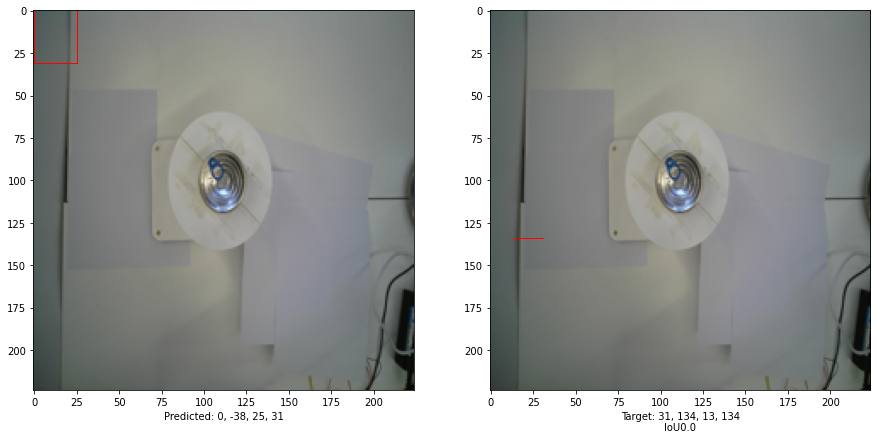

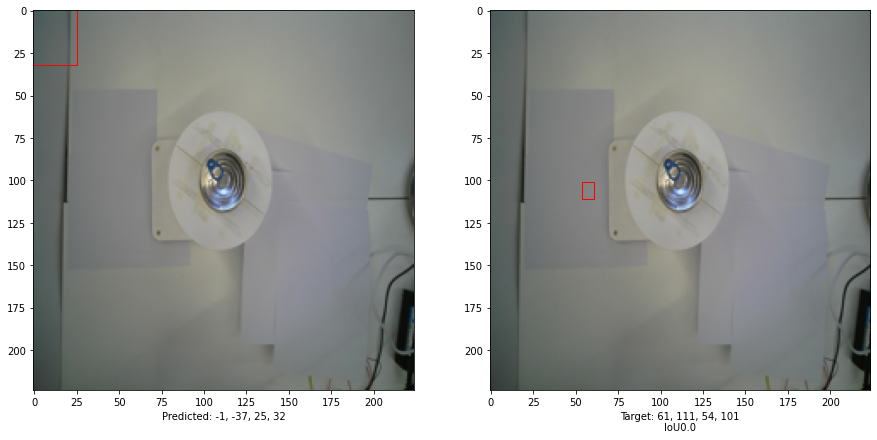

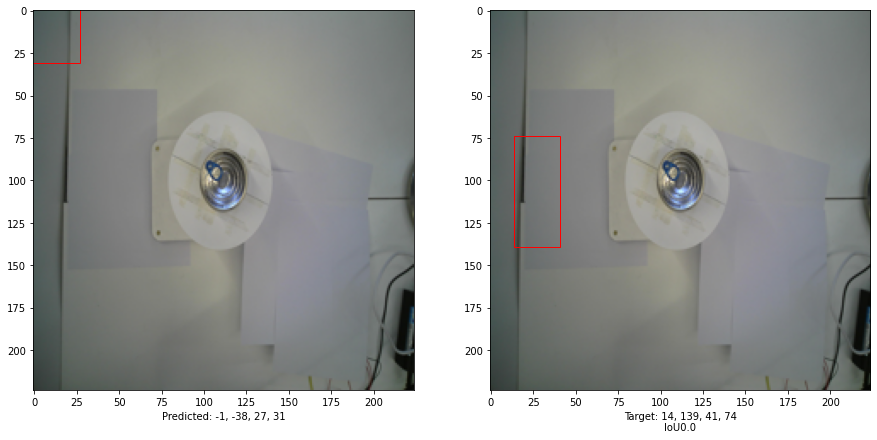

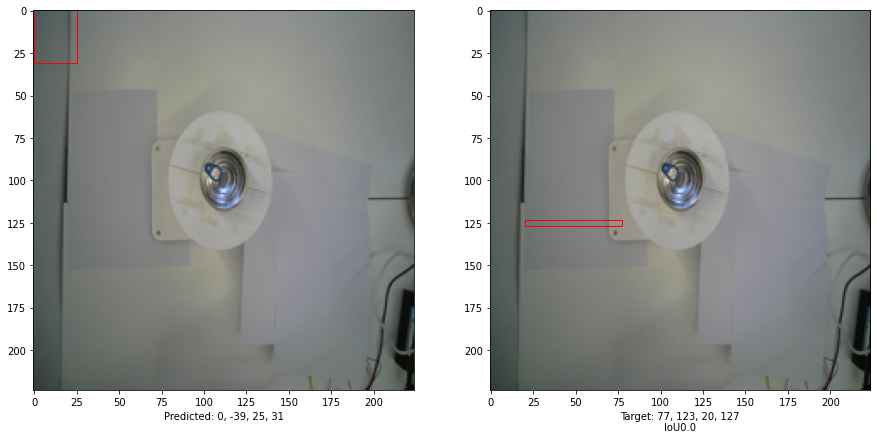

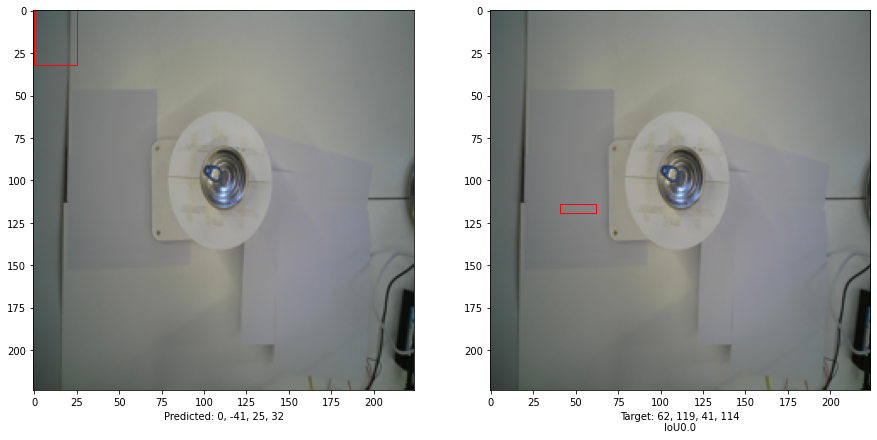

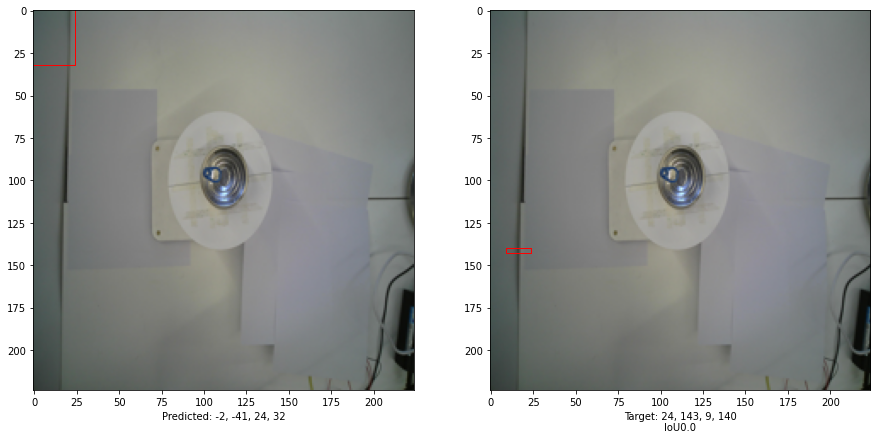

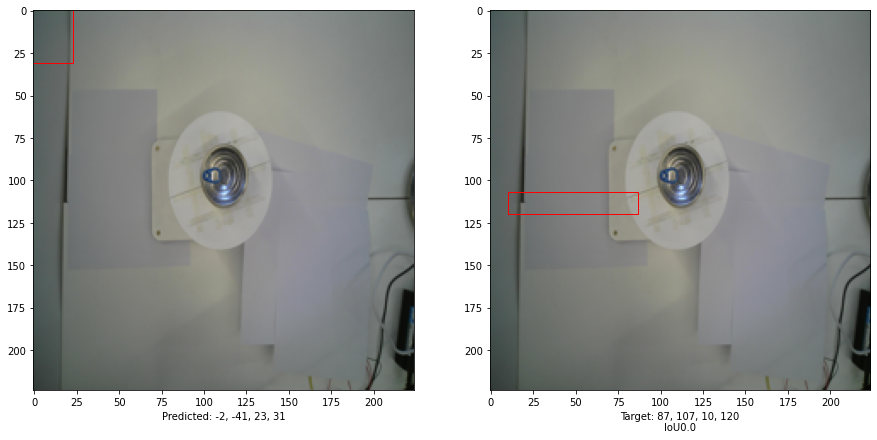

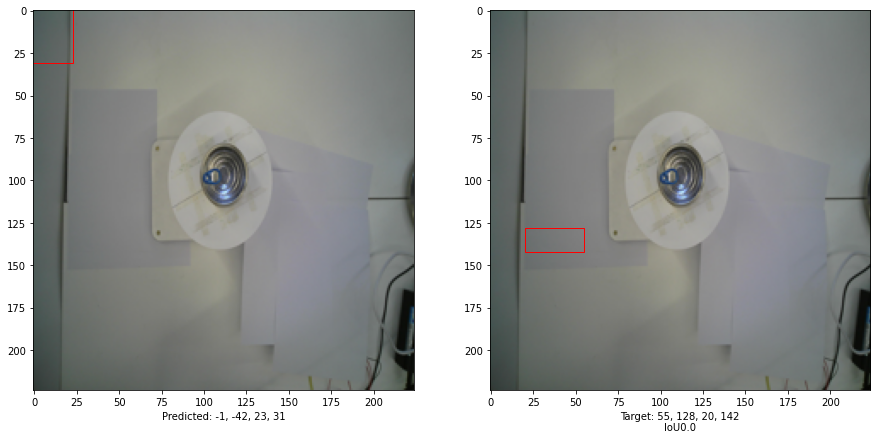

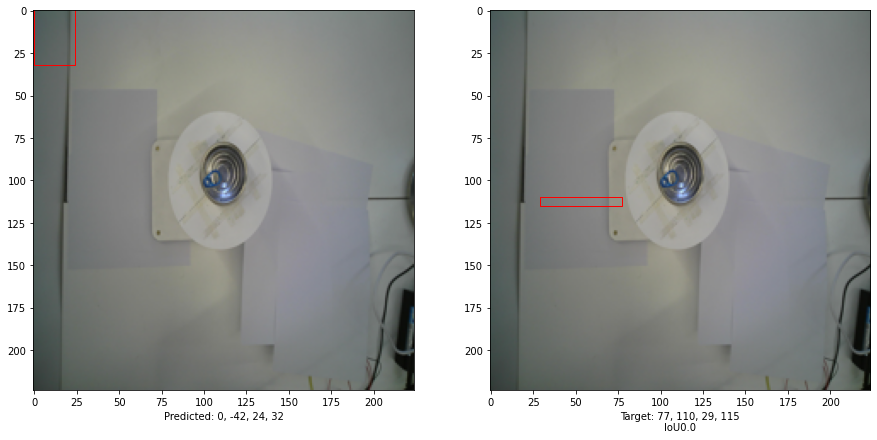

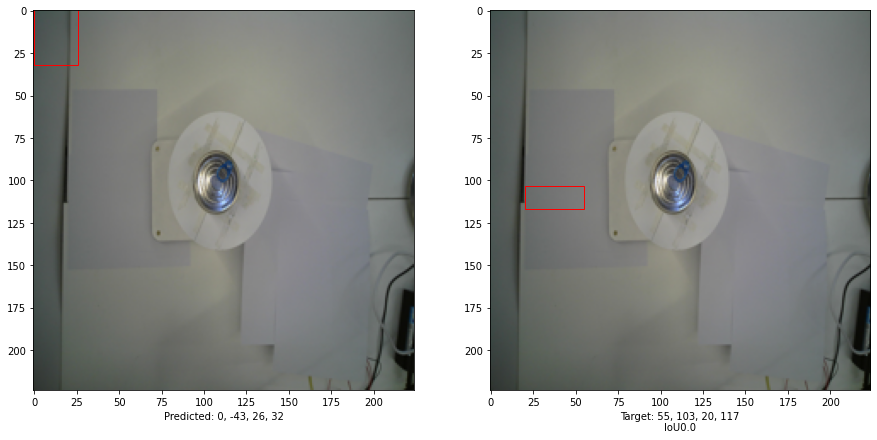

In [127]:
for input_image in x_test[:10]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = model.predict(input_image)[0]

    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()